# Visualize Kaggle Data & Prepare our Training Dataset

What we want to do in this notebook is:

1. Inspect the data
2. Choose data we want to use
3. Create our Training Image Folder

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from src.Extractor import create_our_training_data
from src.Visualizer import plot_original

# global variables
from util import TRAIN_IMG_FOLDER, PRELIM_TRAIN_DF, UPPER_LIMIT_OF_IMAGES, TRAIN_DATA_PATH, TARGET_SHAPE

ModuleNotFoundError: No module named 'seaborn'

## 1. Inspection of Data

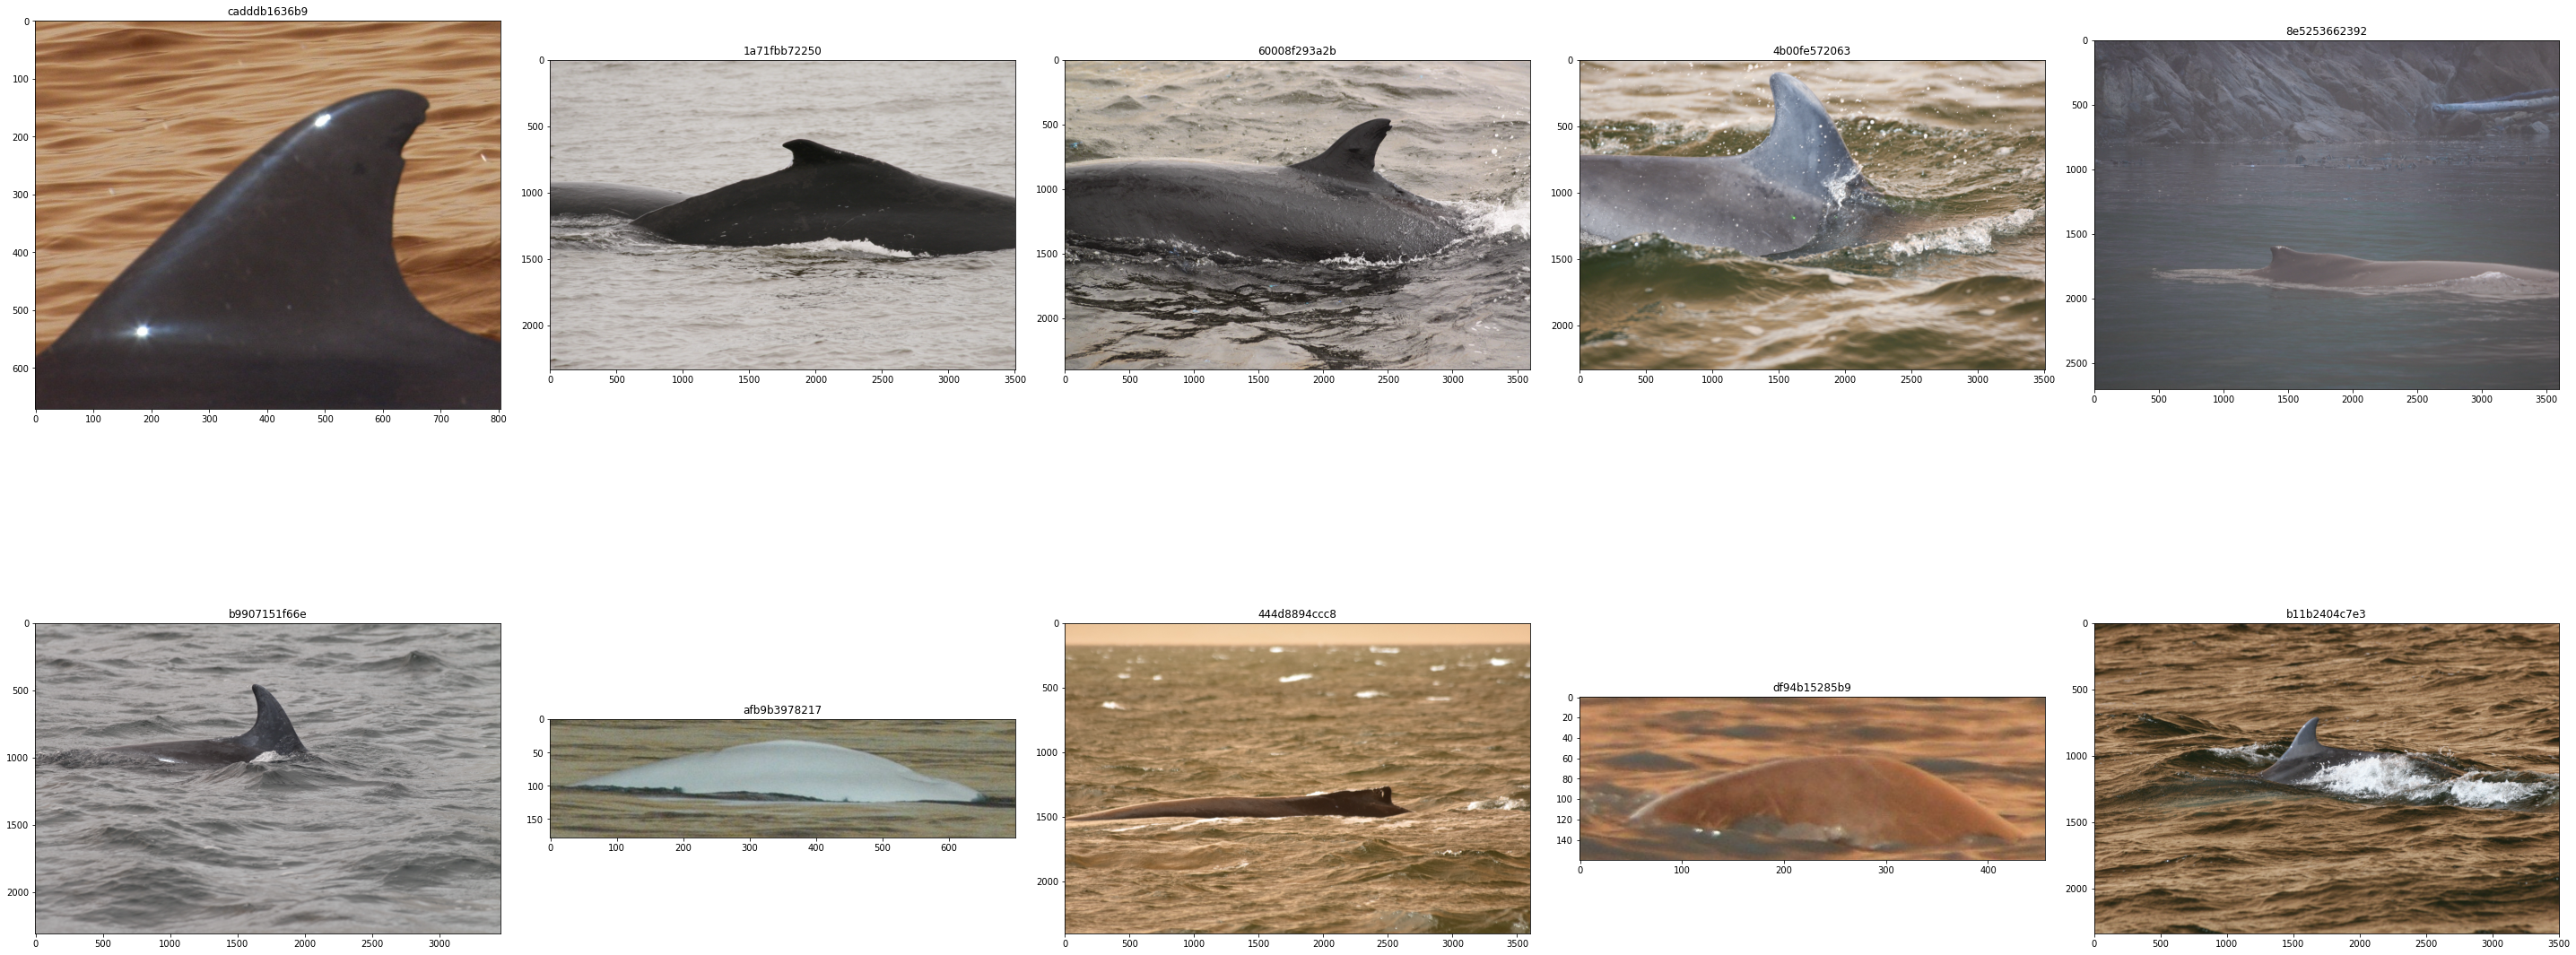

In [4]:
plot_original() # Some example images from our dataset

In [5]:
train_df = PRELIM_TRAIN_DF  # get our data csv from the kaggle data
ids, respective_counts = np.unique(train_df["individual_id"].values, return_counts=True)

In [6]:
train_df.isnull().any()

# We can see our dataset is clean

image            False
species          False
individual_id    False
dtype: bool

In [7]:
find_ending = np.vectorize(lambda x : x[x.find(".")+1:])
set(find_ending(train_df["image"].values))

# And we only have jpgs

{'jpg'}

### Plotting of individual counts

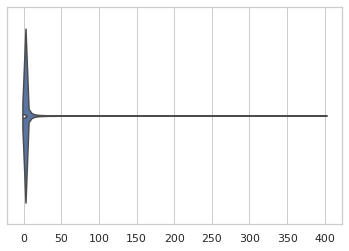

In [8]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=respective_counts)

Wow! That's seems heavily biased towards less pictures per animal, so let us have a look at the lower counts

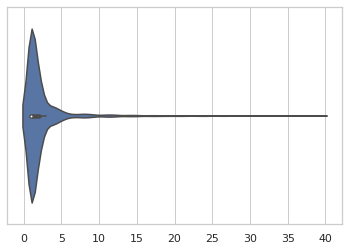

In [9]:
sns.set_theme(style="whitegrid")
ax = sns.violinplot(x=respective_counts[respective_counts<40])

Still heavily biased to the lower counts so let's go lower!

In [10]:
# this will come in handy soon
give_nice_percentage = lambda x, y: int(100 * np.round(x/y, 2))

We have 9258 individuals with only one image.
9258 individuals corresponds to 59% of all individuals.
They make out 18% of the dataset.


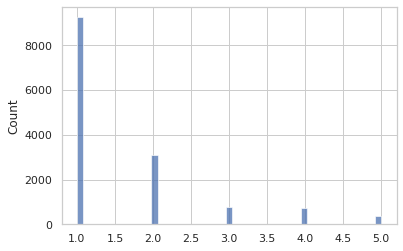

In [11]:
ax = sns.histplot(data=respective_counts[respective_counts<6])
number_of_indiviuals_with_one_image = (respective_counts ==1).sum()
percentage_of_indiviuals_with_one_image =  give_nice_percentage(number_of_indiviuals_with_one_image,len(respective_counts))
their_amount_of_images = respective_counts[respective_counts ==1].sum()
percentage_data = give_nice_percentage(their_amount_of_images,len(train_df))

print(f"""We have {number_of_indiviuals_with_one_image} individuals with only one image.
{number_of_indiviuals_with_one_image} individuals corresponds to {percentage_of_indiviuals_with_one_image }% of all individuals.
They make out {percentage_data}% of the dataset.""")

How we (very unfortunately) can see, the most individuals have only a single picture in the training data.

On the other side of the spectrum we also have some individuals with many images: 

In [12]:
number_of_animals_above_limit = (respective_counts > UPPER_LIMIT_OF_IMAGES).sum()
percentage_of_animals_above_limit = give_nice_percentage(number_of_animals_above_limit,len(respective_counts))
their_amount_of_images = respective_counts[respective_counts > UPPER_LIMIT_OF_IMAGES].sum()
percentage_data = give_nice_percentage(their_amount_of_images,len(train_df))

print(f"""We have {number_of_animals_above_limit} individuals with more then {UPPER_LIMIT_OF_IMAGES} images.
{number_of_animals_above_limit} individuals corresponds to {percentage_of_animals_above_limit}% of all individuals.
They make out {percentage_data}% of the dataset.""")

We have 795 individuals with more then 10 images.
795 individuals corresponds to 5% of all individuals.
They make out 47% of the dataset.


## 2. Choosing our training data

Since triplet training requires atleast 2 positve pictures per individual, we have to discard the individuals with only one picture for training. We only can hope that our model later is generalisis good enough to later theoretically also project them into the latent space in such a way, that they also can be used for classifying. 

In [13]:
# First we throw away all the whales/dolphines with less then 2 images
print(f"We throw away {number_of_indiviuals_with_one_image } single-image individuals and have {np.sum(respective_counts>1)} left.")

ids = ids[respective_counts > 1] # boolean index the ids 

respective_counts= respective_counts[respective_counts > 1] # and counts for later

filter_function = np.vectorize(lambda x: x in ids) # our filter function

train_df = train_df.iloc[filter_function(train_df["individual_id"])] # filter df

train_df.index = range(len(train_df)) # reindex
train_df.head()

We throw away 9258 single-image individuals and have 6329 left.


,image,species,individual_id
0,000562241d384d.jpg,humpback_whale,1a71fbb72250
1,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
2,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
3,00087baf5cef7a.jpg,humpback_whale,8e5253662392
4,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e


On the other site we have already a tiny amount of individuals making out of almost have of all images before disregarding 59% of all indiviuals. Hence our dataset is heavily out of balance. Threrefore we will set an upper limit for maximum images per individual. 

For every indivual of our class with too many images, we deem it sensible to our upper limit images out of their images.

In [14]:
print(f"Our current Upper Maximum is specified in util.py is: {UPPER_LIMIT_OF_IMAGES}.")

Our current Upper Maximum is specified in util.py is: 10.


In [15]:
boolean_mask = np.zeros(len(train_df),dtype=bool)

for animal, count in zip(ids, respective_counts):
    index = train_df[train_df["individual_id"] == animal].index.tolist()
    
    if count > UPPER_LIMIT_OF_IMAGES:
        index = np.random.choice(index,UPPER_LIMIT_OF_IMAGES,replace=False)
        boolean_mask[index]=True
        
    else:
        boolean_mask[index]=True

train_df = train_df.iloc[boolean_mask]
train_df.index = range(len(train_df)) # reindex
train_df.head()

,image,species,individual_id
0,000562241d384d.jpg,humpback_whale,1a71fbb72250
1,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
2,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
3,00087baf5cef7a.jpg,humpback_whale,8e5253662392
4,000be9acf46619.jpg,beluga,afb9b3978217


In [16]:
print(f"We have now already recuced our dataset by {give_nice_percentage(len(train_df),len(PRELIM_TRAIN_DF))}%.")

We have now already recuced our dataset by 50%.


## 3. Create our Training Images

In [17]:
# First let's create a folder for our training data
if TRAIN_DATA_PATH[6:] not in os.listdir("../../"):
    os.makedirs(TRAIN_DATA_PATH)

# append count col to df (how many images exist per idividual)
train_df['individum_count'] = train_df.groupby('individual_id')['individual_id'].transform('count')

# For the training later, int-labels will be more useful than strings
ids = np.unique(train_df["individual_id"].values)
give_int_id = np.vectorize(lambda id_of_animal: int(np.where(ids == id_of_animal)[0]))
train_df["label"] = give_int_id(train_df["individual_id"]) # append int-label col to df

# a unique int-label for each species also doesn't hurt 
species_ids = np.unique(train_df["species"].values)
give_species_int_id = np.vectorize(lambda id_of_animal: int(np.where(species_ids == id_of_animal)[0]))
train_df["species_label"] = give_species_int_id(train_df["species"])

# Let's see the most common species in our dataset
train_df["species_counts"] = train_df.groupby('species_label')["species_label"].transform('count')
train_df = train_df.sort_values(["species_counts"], ascending=False)
train_df.head()

,image,species,individual_id,individum_count,label,species_label,species_counts
5217,35ac2c69f386f3.jpg,beluga,1c75e49514cf,10,711,0,4490
5499,38e56620217453.jpg,beluga,ab8e10730e0c,2,4284,0,4490
17501,b098613b8f01a9.jpg,beluga,a2139d9ef076,10,4045,0,4490
5546,394a900eb7f4ba.jpg,beluga,e5cffdb1b51d,10,5714,0,4490
17505,b0a13dbecd9803.jpg,beluga,d218dff09dab,10,5254,0,4490


In [18]:
train_df.to_csv(TRAIN_DATA_PATH + "/individual_data.csv") # Write our data to csv

### Creating Training Images

For this we use the prespecified function *create_our_training_data* from Extractor.py.

In [ ]:
create_our_training_data(TRAIN_IMG_FOLDER, TRAIN_DATA_PATH, TARGET_SHAPE, task="individual")

 20%|█▉        | 5013/25544 [01:52<10:02, 34.08it/s]